In [3]:
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
import os , operator
from random import random , randrange
from marchhare.Plotting import *

# ~~ Constants , Shortcuts , Aliases ~~
EPSILON = 1e-7 # Assume floating point errors below this level
infty = 1e309 # URL: http://stackoverflow.com/questions/1628026/python-infinity-any-caveats#comment31860436_1628026
endl = os.linesep # Line separator
pyEq = operator.eq # Default python equality
piHalf = pi/2

def eq( op1 , op2 ): 
    """ Return true if op1 and op2 are close enough """
    return abs(op1 - op2) <= EPSILON

def vec_unit( vec ): 
    """ Return a unit vector in the direction of 'vec', using numpy """
    mag = np.linalg.norm( vec )
    return np.divide( vec , 1 if eq( mag , 0 ) else mag )

def vec_mag( vec ): 
    """ Return the magnitude of a vector """
    return np.linalg.norm( vec )

def vec_dif_mag( vec1 , vec2 ):
    """ Return the magnitude of the vector difference between 'vec1' and 'vec2' """
    return vec_mag( np.subtract( vec1 , vec2 ) )

def vec_linspace( vec1 , vec2 , numPts ):
    """ Return a list of 'numPts' points (vectors) evenly spaced from 'vec1' to 'vec2', inclusive """
    diff = np.subtract( vec2 , vec1 ) # Vector from point 1 to point 2
    direction = vec_unit( diff ) # Direction of the vector between the two
    span = vec_mag( diff ) # the Euclidian distance between the two points
    ptsList = [] 
    for value in np.linspace(0, span, num=numPts): # For each value in the range
        ptsList.append( np.add( vec1 , # append the sum of the first point and
                                np.multiply( direction , # a vector that is an additional space along the difference
                                             value ) ) )
    return ptsList

def vec_random( dim ): 
    """ Return a random vector in R-'dim' space with coordinates in [0,1) """
    rtnVec = []
    for i in range(dim):
        rtnVec.append( random() )
    return rtnVec
        
def vec_random_range( dim , limLo , limHi ): 
    """ Return a vector in which each element takes on a random value between 'limLo' and 'limHi' with a uniform distribution """
    rtnVec = []
    randVec = vec_random( dim )
    span = abs( limHi - limLo )
    for elem in randVec:
        rtnVec.append( elem * span + limLo )
    return rtnVec
        
def add_uni_box_noise( data , noiseOneSide ):
    """ Add random noise in each direction """
    rtnNoisy = []
    dim = len( data[0] )
    for datum in data:
        rtnNoisy.append( np.add( datum , vec_random_range( dim , -noiseOneSide , noiseOneSide ) ) )
    return rtnNoisy
    
def noisy_segment( vec1 , vec2 , numPts , noiseOneSide ):
    """ Return points perturbed from a line segment """
    orig = vec_linspace( vec1 , vec2 , numPts )
    return add_uni_box_noise( orig , noiseOneSide )

def throw_outliers( data , prob , noiseOneSide ):
    """ Perturb each point with 'prob' by a one-sided distance of 'noiseOneSide' in each dimension """
    rtnData = []
    dim = len( data[0] )
    for datum in data:
        if random() < prob:
            rtnData.append( np.add( datum , vec_random_range( dim , -noiseOneSide , noiseOneSide ) ) )
        else:
            rtnData.append( datum[:] )
    return rtnData
        
    

In [123]:
def gen_data( noiseOneSide , outlierWidth ):
    rtnData = []
#     rtnData.extend( noisy_segment( [ -10 ,  0 ] , [ -10 ,  20 ] , 50 , noiseOneSide ) )
    rtnData.extend( noisy_segment( [ -10 , 20 ] , [  10 ,  20 ] , 50 , noiseOneSide ) )
#     rtnData.extend( noisy_segment( [  10 , 20 ] , [  10 ,   0 ] , 50 , noiseOneSide ) )
    rtnData = throw_outliers( rtnData , 0.20 , outlierWidth )
    return rtnData
    

In [169]:
from math import ceil , sqrt

def np_add( *args ):
    """ Perform 'np.add' on more than two args """
    if len( args ) > 2: # If there are more than 2 args, add the first arg to recur on remainder of args
        return np.add( args[0] , np_add( *args[1:] ) ) # Note the star operator is needed for recursive call, unpack to positional args
    else: # base case, there are 2 args*, use vanilla 'np.add'
        return np.add( args[0] , args[1] ) # *NOTE: This function assumes there are at least two args, if only 1 an error will occur

def vec_avg( *vectors ): 
    """ Return a vector that is the average of all the 'vectors', equal weighting """
    vecSum = np_add( *vectors ) # NOTE: This function assumes that all vectors are the same dimensionality
    return np.divide( vecSum , len( vectors ) * 1.0 )

def d_point_to_segment_2D( point , segment ): 
    """ Return the shortest (perpendicular) distance between 'point' and a line 'segment' """
    # URL: http://mathworld.wolfram.com/Point-LineDistance2-Dimensional.html
    segPt1 = segment[0] ; segPt2 = segment[1]
    return abs( ( segPt2[0] - segPt1[0] ) * ( segPt1[1] - point[1] ) - \
                ( segPt1[0] - point[0] ) * ( segPt2[1] - segPt1[1] ) ) / sqrt( ( segPt2[0] - segPt1[0] )**2 + ( segPt2[1] - segPt1[1] )**2 )

def vec_dif_unt( vec1 , vec2 ):
    """ Return the unit vector difference between 'vec1' and 'vec2' """
    return vec_unit( np.subtract( vec1 , vec2 ) )

def vec_proj( a , b ): 
    """ a projected onto b, a scalar length, using numpy """
    return np.dot(a,b) / np.linalg.norm(b) # Note that the result will be negative if the angle between a and b is > pi/2

def dist_beyond_segment( point , segment ):
    """ Return the distance that 'point' lies beyond 'segment' """
    pnt1 = segment[0] ; pnt2 = segment[1]
    dist = 0
    # Point 1
    xfrmPnt = np.subtract( point , pnt1 )
    dirVec  = vec_dif_unt( pnt2 , pnt1 )
    dist    = max( dist , -vec_proj( xfrmPnt , dirVec ) )
    # Point 2
    xfrmPnt = np.subtract( point , pnt2 )
    dirVec  = vec_dif_unt( pnt1 , pnt2 )
    dist    = max( dist , -vec_proj( xfrmPnt , dirVec ) )
    
    return dist

def score_segment_model( data , segmentFit , distAccept ):
    """ Return the fraction of 'data' that is within perpendicular 'distAccept' of 'segmentFit' """
    dataLen   = len( data )
    numAccept = 0
    inliers   = []
    for datDex , datum in enumerate( data ):
#         dist = d_point_to_segment_2D( datum , segmentFit ) + dist_beyond_segment( datum , segmentFit ) * 0.0
        dist = d_point_to_segment_2D( datum , segmentFit )
        if dist <= distAccept and dist_beyond_segment( datum , segmentFit ) < 2.0:
            numAccept += 1
            inliers.append( datDex )
    return numAccept / dataLen , inliers

def vec_proj_onto( a , b ): 
    """ a projected onto b,  vector in the direction of b """
    return np.multiply( vec_unit( b ) , vec_proj( a , b ) )

def segment_2D_RANSAC( data , iterLimit , sampleFrac , distCrit , acceptFrac ):
    """ Attempt to a line segment to noisy data """
    # The input to the RANSAC algorithm is:
    #    a set of observed data values, 
    #    a way of fitting some kind of model to the observations, 
    #    and some confidence parameters. 
    # RANSAC achieves its goal by repeating the following steps:
    itNum      = 0
    dataLen    = len( data )
    mid        = dataLen // 2
    bgnRng     = [ 0   , mid+1   ]
    endRng     = [ mid , dataLen ]
    slcNum     = ceil( dataLen * sampleFrac )
#     bestModel  = [ data[0][:] , data[-1][:] ]
    bestModel  = [[0,0],[0,0]]
#     distAccept = vec_dif_mag( *bestModel ) * distFrac
#     bestScore  = score_segment_model( data , bestModel , distAccept )
    bestScore  = 0.0
    bestDices  = []
#     print( bestScore )
    while itNum < iterLimit:
        
        # 1. Select a random subset of the original data. Call this subset the hypothetical inliers.
        bgnSmp = []
        endSmp = []
        for i in range( slcNum ):
            bgnSmp.append( data[ randrange( *bgnRng ) ][:] )
            endSmp.append( data[ randrange( *endRng ) ][:] )
            
        # 2. A model is fitted to the set of hypothetical inliers.
        bgnPnt   = vec_avg( *bgnSmp )
        endPnt   = vec_avg( *endSmp )
        model    = [  bgnPnt[:] , endPnt[:] ]
        midPnt   = vec_avg( endPnt , bgnPnt )
        dirVec12 = vec_dif_unt( endPnt , bgnPnt )
        dirVec21 = vec_dif_unt( bgnPnt , endPnt )
        bgnPnt   = midPnt
        endPnt   = midPnt
        
        # Extend , Try to find the edges of the inliers (This is splitting model calc a bit)
        for i in range( slcNum ):
            datum1 = np.subtract( bgnSmp[i] , bgnPnt )
            if vec_proj( datum1 , dirVec12 ) < 0:
                if d_point_to_segment_2D( bgnSmp[i] , model ) < distCrit:
                    bgnPnt = np.add( bgnPnt , vec_proj_onto( datum1 , dirVec12 ) )
            datum2 = np.subtract( endSmp[i] , endPnt )
            if vec_proj( datum2 , dirVec21 ) < 0:
                if d_point_to_segment_2D( endSmp[i] , model ) < distCrit:
                    endPnt = np.add( endPnt , vec_proj_onto( datum2 , dirVec21 ) )
            
        # 3. All other data are then tested against the fitted model. 
        #    Those points that fit the estimated model well, according to some model-specific loss function, 
        #    are considered as part of the consensus set.
#         distAccept = vec_dif_mag( bgnPnt , endPnt ) * distFrac
        score , inliers = score_segment_model( data , [ bgnPnt , endPnt ] , distCrit )
#         print( score )
        # 3.5. We must return a model
        if score > bestScore:
            bestModel = [ bgnPnt , endPnt ]
            bestScore = score
            bestDices = inliers
        # 4. The estimated model is reasonably good if sufficiently many points have been classified as part of the consensus set.
        if bestScore >= acceptFrac:
            print( "EARLY EXIT" ) 
            break
        # 5. Afterwards, the model may be improved by reestimating it using all members of the consensus set.
        # FIXME : IMPROVE?
        itNum += 1
    return bestModel , inliers
    

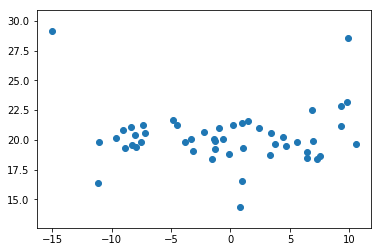

In [196]:
nsyDat = gen_data( 1.75 , 10 )
X,Y = split_to_2D( nsyDat )
plt.axis('equal')
plt.scatter(X,Y)

EARLY EXIT
[array([-11.0269618 ,  20.55465163]), array([ 9.27530661, 20.19603437])]


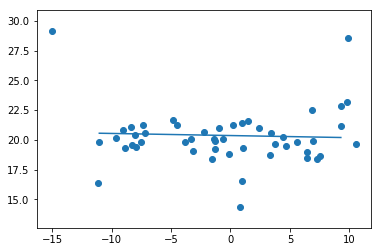

In [197]:
model , inliers = segment_2D_RANSAC( nsyDat , 50 , 0.15 , 1.4 , 0.70 )
print( model )

X,Y = split_to_2D( nsyDat )
modX,modY = split_to_2D( model )
# plt.hold()
plt.axis('equal')
plt.scatter(X,Y)
plt.plot(modX,modY)
# plt.hold()